# Data Mining Course Spark Exercise
## Sharif University of Technology

In this notebook, we are going to analyze tweets.
Outline of the exercise:
* Recommender systems
* Random Walk on graph
* Pixie and simRank algorithms

# Name: Mohammad Mehdi Zare
# Student Number: 


In [60]:
# installation
!pip install pyspark
!pip install findspark
!pip install networkx
!pip install plotly

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("HW4") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

In [3]:
# libraries
import json
import numpy as np
import matplotlib.pyplot as plt
from itertools import groupby
from operator import itemgetter
from numpy import dot
from numpy.linalg import norm
import random
random.seed(10)

In [4]:
# read data
tweets_rdd = sc.textFile("twitter_data.jsonl")

In [5]:
# load json data 
json_rdd = tweets_rdd.map(lambda x : json.loads(x))
json_formatted_str = json.dumps(json_rdd.take(1)[0], indent=4)
print(json_formatted_str)

{
    "publish_source": "<a href=\"https://mobile.twitter.com\" rel=\"nofollow\">Twitter Web App</a>",
    "in_reply_to_status_id_str": null,
    "in_reply_to_user_id_str": null,
    "in_reply_to_status_id": null,
    "in_reply_to_user_id": null,
    "in_reply_to_screen_name": null,
    "truncated": false,
    "is_quote_status": true,
    "retweet_count": 32,
    "reply_count": 129,
    "quote_count": 12,
    "favorite_count": 162,
    "favorited": false,
    "retweeted": false,
    "possibly_sensitive": false,
    "lang": "fa",
    "geo": null,
    "view_count": 27433,
    "tweet_type": "quoted",
    "emojis": null,
    "text": "\u067e\u0647\u0644\u0648\u0627\u0646\u200c\u067e\u0647\u0644\u0648\u06cc\u061b \u06cc\u0627\u0631 \u062f\u0648\u0627\u0632\u062f\u0647\u0645 \u062e\u0645\u06cc\u0646\u06cc\u060c \u062e\u0627\u0645\u0646\u0647\u200c\u0627\u06cc \u0648 \u062c.\u0627!\n\n\u0641\u06a9\u0631 \u0645\u06cc\u200c\u06a9\u0646\u06cc\u062f \u0627\u06af\u0631 \u0631\u0636\u0627 \u067e\u06

In [6]:
# here I create node for graph
class Node:
    def __init__(self, id):
        self.id = id
        self.neighbors = []
        self.visited=0;

    def add_neighbors(self, node):
        for neighbor in self.neighbors:
            if(neighbor.id == node.id):
                return None
        self.neighbors.append(node)
        
    def get_random_neighbor(self):
        size=len(self.neighbors)
        return self.neighbors[random.randint(0,size-1)]
 

In [7]:
# here we create a graph
class Graph:
    def __init__(self):
        self.nodes = {}

    def contains(self, id):
        if(self.nodes.get(id)==None):
            return False
        return True

    # Return the node with the id, create and return new node if not found
    def find(self, id):
        if(not self.contains(id)):
            new_node = Node(id)
            self.nodes[id]=new_node
            return new_node
        else:
            return self.nodes.get(id)

    def add_edge(self, user, tweet):
        user_node = self.find(user)
        tweet_node = self.find(tweet)
        user_node.add_neighbors(tweet_node)
        tweet_node.add_neighbors(user_node)

    def display(self):
        for node in self.nodes.values():
            print(f'{node.id} links to {[child.id for child in node.neighbors]}')


    # def createLists(self):
    #     node_list=[]
    #     from_list=[]
    #     to_list=[]
    #     for node in self.nodes.values():
    #         node_list.append(node.id)
    #         for child in node.neighbors: 
    #             from_list.append(node.id)
    #             to_list.append(child.id)

    #     return node_list,from_list,to_list

In [8]:
# In data, some tweets have incomplete data
incomp=json_rdd.filter(lambda x: x['tweet_type']=="quoted" and x.get('quoted_status').get('id',0)==0).collect()
print("sample of incomplete data: ")
print(incomp[1])
print("number of incomplete data : "+str(len(incomp)))

sample of incomplete data: 
{'publish_source': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id_str': None, 'in_reply_to_status_id': None, 'in_reply_to_user_id': None, 'in_reply_to_screen_name': None, 'truncated': False, 'is_quote_status': True, 'retweet_count': 1, 'reply_count': 0, 'quote_count': 1, 'favorite_count': 3, 'favorited': False, 'retweeted': False, 'possibly_sensitive': None, 'lang': 'fa', 'geo': None, 'view_count': 235, 'tweet_type': 'quoted', 'emojis': None, 'text': 'ننویسد اقا اون مهریه کوفتی رو تعداد بالا ننویسید!\nاونی که به مهر بالا اصرار داره دیگه به چه زبونی بهتون بگه میخواد بعدا بدبختتون کنه؟\nیا ازدواج نکنید یا از مهر بالا فرار کنید', 'user': {'id': '1363594775539159045', 'id_str': '1363594775539159045', 'created_at': 1613941316, 'name': 'وکیل الرعایا', 'screen_name': 'md_s_law', 'location': 'tehran', 'description': 'حسبنا الله و نعم الوکیل', 'verified': False, 'followers_count': 1124, 'friends_count': 1431, 'listed_count': 1, 'favourites_count': 3955

In [9]:
# a function to create (user_id, tweet_id) as edge of biprate graph, in this function I just consider tweets type (replied, generated, retweet, quoted)
# and for type generated and replied make a tuple and for retweet and quoted make two tuple.
def create_triple(x):
    id=x['id']
    user_id = x['user']['id']
    term=x['tweet_type']
    if term == "replied":
        id_r = x['in_reply_to_status_id_str']
        return [(user_id, id_r)]
    elif term == "quoted":
        if x.get('quoted_status').get('id',0)!= 0:
            id_q = x['quoted_status']['id']
            return [(user_id, id), (user_id, id_q)]
        else: 
            return [(user_id, id)]
    elif term == "generated":
        return [(user_id,id)]
    elif term == "retweeted":
        id_r = x['retweeted_status']['id']
        return[(user_id, id), (user_id, id_r)]


In [10]:
# create biprate graph for pixie algorithm
user_tweet_data= json_rdd.map(lambda x: (create_triple(x)))
edges= user_tweet_data.flatMap(lambda x: x)\
.filter(lambda x: x[0]!=None and x[1]!=None)\
.collect()

In [11]:
edges

[('1180273217795170304', '1719504915700015121'),
 ('1180273217795170304', '1718426467254566975'),
 ('1689500371377401856', '1719505170222964822'),
 ('1283249761995362305', '1719452613375062038'),
 ('875259218370199552', '1719505296920330649'),
 ('1323619702925455361', '1719505720721179046'),
 ('854179818178347008', '1719506014347632644'),
 ('1185342890064650241', '1719497061778051558'),
 ('66147692', '1719506830332699085'),
 ('1316456805531299840', '1719506844430053655'),
 ('88447782', '1719506990710263937'),
 ('1123733391566954497', '1719507017952342279'),
 ('1573790732292440064', '1719507345871696038'),
 ('1573790732292440064', '1714422783424545012'),
 ('2612721125', '1719303427488985434'),
 ('1645723091459342341', '1719507458811429237'),
 ('1645723091459342341', '1719468029929509057'),
 ('1483240827338039300', '1719391932986675522'),
 ('975589943278911488', '1718987782343790676'),
 ('720836845', '1719419712185020868'),
 ('1719506958242439168', '1719508444699590677'),
 ('3252809935',

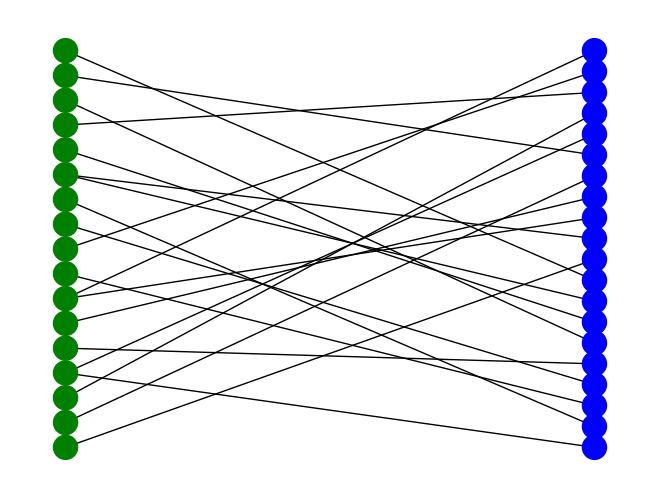

In [12]:
# draw a part of graph 
import networkx as nx

edges1=edges[:20]

users, tweets= list(zip(*edges1))
users=list(set(users))
tweets=list(set(tweets))
B = nx.Graph()
B.add_nodes_from(users, bipartite = 0) # Add the node attribute "bipartite"
B.add_nodes_from(tweets, bipartite = 1)
B.add_edges_from(edges1)

user_l=len(users)
tweet_l=len(tweets)
gren=['green']*user_l
bl=['blue']*tweet_l
gren.extend(bl)

u = [n for n in B.nodes if B.nodes[n]['bipartite'] == 0]
pos = nx.bipartite_layout(B, u)
nx.draw(B, pos=pos, node_color=gren)
plt.show()

In [13]:
graph = Graph()
for user, tweet in edges:
    graph.add_edge(user, tweet)

In [20]:
def pixie(iterationNum, graph, user, alpha):
    simillar_nodes={}
    main_user=graph.find(user)
    pin_node= main_user
    for i in range(0,iterationNum):
        board_node=pin_node.get_random_neighbor()
        pin_node=board_node.get_random_neighbor()
        pin_node.visited+=1
        if(pin_node.visited>20):
            simillar_nodes[pin_node.id]=pin_node.visited
        if(len(simillar_nodes)>100):
            break
        if(random.random()<alpha):
            pin_node= main_user
    return simillar_nodes


In [28]:
sample_user='1004052664882118657'
ans=pixie(100000, graph, sample_user,.2)
sorted(ans.items(), key=lambda item: item[1], reverse=True)[1:5]

[('1117524754678681600', 17445),
 ('1470253980664147968', 12747),
 ('1583401081631031299', 11576),
 ('1381165297021939713', 4543)]

In [17]:
# these users are found as similar in collaborative filtering  : 
# [('1583401081631031299', 0.1091089451179962), ('1117524754678681600', 0.0944911182523068), ('1470253980664147968', 0.3779644730092272)]
# user may like these tweets:  
# ['1720330395323941009' '1720835833161195738' '1720837641589907668'
#  '1728131934784745705' '1729194735754265083']